# Accessing ITS_LIVE data via S3 bucket

This notebook will demonstrate how to access cloud-hosted Inter-mission Time Series of Land Ice Velocity and Elevation (ITS_LIVE) data from AWS S3 buckets. Here you will find examples of how to successfully access cloud-hosted data as well as some common errors and issues you may run into along the way, what they mean, and how to resolve them. 

Learning goals:
- accessing and inspecting data stored in s3 buckets 

### 6/11 still to add
 - probably need to clean up the individual data cube builds at the beginning,  introduce read_in_s3() sooner and use that instead of by hand, add try: , except: to read_in_s3()
 - get_bbox() should show something about the granule id/location as a text printout ideally as well
 - maybe show a basic beginning example of looking at a single scene, plotting a few different time steps to show variability in coverage


In [4]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from shapely.geometry import Polygon
from shapely.geometry import Point
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import cartopy.feature as cfeature
import json

## Finding / selecting data

The ITS_LIVE project details a number of data access options on their [website](https://its-live.jpl.nasa.gov/#access). Here, we will be accessing ITS_LIVE data in the form of `zarr` data cubes that are stored in **s3 buckets** hosted by Amazon Web Services (AWS). 

Let's begin by looking at the [GeoJSON Data Cubes Catalog](https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json). 
This catalog contains spatial information and properties of ITS_LIVE data cubes as well as the url used to access each cube. Let's take a look at the entry for a single data cube and the information that it contains:

![itslive_info](images/screengrab_itslive_catalog_entry.png)

The top portion of the picture shows the spatial extent of the data cube in lat/lon units. Below that, we have properties such as the epsg code of the coordinate reference system, the spatial footprint in projected units and the url of the zarr object. 

Let's take a look at the url more in-depth: 

![itslive_url](images/itslive_url.png)

From this link we can see that we are looking at its_live data located in an s3 bucket hosted by amazon AWS. We cans see that we're looking in the data cube directory and what seems to be version 2. The next bit gives us information about the global location of the cube (N40E080). The actual file name `ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr` tells us that we are looking at ice velocity data (its_live also has elevation data), in the CRS associated with EPSG 32645 (this code indicates UTM zone 45N). X250000_Y4750000 tells us more about the spatial footprint of the datacube within the UTM zone. 

**NOTE**
This catalog provides http links to the zarr objects. To successfully point to the objects that we're looking for in s3 buckets, we need to make a few changes to the links:
- replace 'http' with 's3'
- delete '.s3.amazonaws.com' </br>

so the correct url should read: </br>

    `s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr`


## Accessing s3 data from python

We've found the url associated with the tile we want to access, let's try to open the data cube using `xarray`

In [5]:
url_x25_y475 = 's3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr'
data_cube_x25_y475 = xr.open_dataset(url_x25_y475, engine = 'zarr')

ConnectTimeoutError: Connect timeout on endpoint URL: "http://169.254.169.254/latest/api/token"

As you can see, this doesn't quite work. We need to specify a bit more information for xarray to be able to access and load the data cube:

In [6]:
data_cube_x25_y475 = xr.open_dataset(url_x25_y475, engine= 'zarr',
                                    storage_options = {'anon':True})

This one worked! Let's stop here and define a function that we can use for a quick inspection of this data

In [7]:
def get_bbox_single(input_xr):
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    #print(input_xr.mapping.spatial_epsg)
    #print(f"epsg:{input_xr.mapping.spatial_epsg}")
    crs = f"epsg:{input_xr.mapping.spatial_epsg}"
    #crs = {'init':f'epsg:{input_xr.mapping.spatial_epsg}'}
    #crs = 'epsg:32645'
    #print(crs)

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    polygon = polygon.to_crs('epsg:4326')

    bounds = polygon.total_bounds
    bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]

    states_provinces = cfeature.NaturalEarthFeature(
        category = 'cultural',
        name = 'admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(states_provinces)

    ax.set_extent(bounds_format, crs = ccrs.PlateCarree())

    polygon.plot(ax=ax, facecolor = 'none', edgecolor='red', lw=1.)




Let's also write a quick function for reading in s3 objects from http urls. This will come in handy when we're trying to test multiple urls

In [50]:
def read_in_s3(http_url):
    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(s3_url, engine = 'zarr',
                                storage_options={'anon':True},
                                chunks = 'auto')

    return datacube

Now let's take a look at the cube we've already read in:

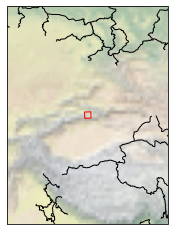

In [9]:
get_bbox_single(data_cube_x25_y475)

Now we can see where this granule lies. Let's try another url:

In [13]:
#this url doen'st work
url_x35_y305 = 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3350000.zarr'
dc_x35_y305 = read_in_s3(url_x35_y305)
                                    #engine= 'zarr',
                                    #storage_options = {'anon':True})


/var/folders/y9/k06gyzdx25z64l_tdt_q2xv9s680sz/T/ipykernel_35680/4261528005.py:5: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


GroupNotFoundError: group not found at path ''

This link doesn't work. From the error we're getting, it looks like it's not working because the zarr file isn't in the location that we're pointing to with the url we supply. As cloud-based datasets are developed and maintained, the locations of specific objects will change and sometimes metadata doesn't always catch up, so this may be an error you'll encounter more than once. 

Let's try another url: 

In [15]:
url_x35_y315 = 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3150000.zarr'

dc_x35_y315 = read_in_s3(url_x35_y315)
                           

## Searching catalog of s3 urls

We know that some zarr objects are located at the supplied urls but that some aren't. We have the entire catalog, but it would be a pain to look through each of those urls individually so let's write a function to find out which urls are working and which arent

In [16]:
import urllib.request
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url:
    itslive_catalog = json.loads(url.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In python, the json object has the form of nested dictionaries that contain information about all of the its_live datacubes. Here we'll show two options for filtering the catalog: one for selecting granules that contain a specific point and a second that returns all granules within a single UTM zone (specified by epsg code). This will let us take stock of the spatial coverage of data cubes located at **working urls** within a certain UTM zone. You could easily tewak this function (or write your own!) to select granules based on different properties. Play around with the `itslive_catalog` object to become more familiar with the data it contains and different options for indexing.

## Selecting data cubes by UTM zone


In [34]:
def find_granules_by_epsg(input_dict, input_epsg):
    '''this function takes a dictionary that is a representation of itslive data cube geojson catalog as well as an 
    epsg code. it makes an intermediate object that is a list of all s3 urls for that utm region/epsg code. it
    then tried to open each zarr url as an xarray dataset and returns a list of the ones that are able to be opened
    successuflly (ie. the zarr file exists at the s3 url). each element of the return list is an xr dataset'''
    
    epsg_ls = []
        
    for granule in range(len(input_dict['features'])):
        
        if input_dict['features'][granule]['properties']['data_epsg'] == input_epsg:
            
            http_url = input_dict['features'][granule]['properties']['zarr_url']
            s3_url = http_url.replace('http', 's3')
            s3_url = s3_url.replace('.s3.amazonaws.com','')
            epsg_ls.append(s3_url)
     
    datacube_ls = []
    for element in range(len(epsg_ls)):
        try:
            #datacube_ls.append(read_in_s3(epsg_ls[element]))
            datacube_ls.append(xr.open_dataset(epsg_ls[element], engine = 'zarr',
                                storage_options={'anon':True}))
        except ValueError:
            print('nothing there ¯\_(ツ)_/¯ ')
            
    return datacube_ls
   

In [93]:
granule_ls_32645 = find_granules_by_epsg(itslive_catalog, 'EPSG:32645')
granule_ls_32645


[<xarray.Dataset>
 Dimensions:                    (mid_date: 20549, y: 833, x: 833)
 Coordinates:
   * mid_date                   (mid_date) datetime64[ns] 2020-02-07T17:10:52....
   * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
   * y                          (y) float64 3.2e+06 3.2e+06 ... 3.1e+06 3.1e+06
 Data variables: (12/54)
     acquisition_date_img1      (mid_date) datetime64[ns] ...
     acquisition_date_img2      (mid_date) datetime64[ns] ...
     autoRIFT_software_version  (mid_date) <U5 ...
     chip_size_height           (mid_date, y, x) float32 ...
     chip_size_width            (mid_date, y, x) float32 ...
     date_center                (mid_date) datetime64[ns] ...
     ...                         ...
     vy_error_mask              (mid_date) float64 ...
     vy_error_modeled           (mid_date) float64 ...
     vy_error_slow              (mid_date) float64 ...
     vy_stable_shift            (mid_date) float64 ...
     vy_stable_shift_

This function returns a list of xarray objects that correspond to all of the zarr urls for that region that were able to be successfully accessed.

Let's write a function to visualize the coverage:

In [38]:
def get_bbox_group(input_ls, bounds = [-180, 180, -90, 90]): 
    
    '''plots the spatial extents of a list of datacubes'''
    
    poly_ls = []
    
    for xr_obj in range(len(input_ls)):
        '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
        currently only working for granules in crs epsg 32645'''

        xmin = input_ls[xr_obj].coords['x'].data.min()
        xmax = input_ls[xr_obj].coords['x'].data.max()
        ymin = input_ls[xr_obj].coords['y'].data.min()
        ymax = input_ls[xr_obj].coords['y'].data.max()

        pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

        
        crs = f"epsg:{input_ls[xr_obj].mapping.spatial_epsg}" #should be format: 'epsg:32645'
        #print(crs)

        polygon_geom = Polygon(pts_ls)
        polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
        polygon = polygon.to_crs('epsg:4326')
        poly_ls.append(polygon)

    bounds_format = [bounds[0], bounds[1], bounds[2], bounds[3]]
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(bounds_format, crs = ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'black'}

    for element in range(len(poly_ls)):
            
        #polygon.plot(ax=ax, facecolor = 'none', edgecolor='red', lw=1.)
        poly_ls[element].plot(ax=ax, facecolor='none', edgecolor='red', lw=1.)


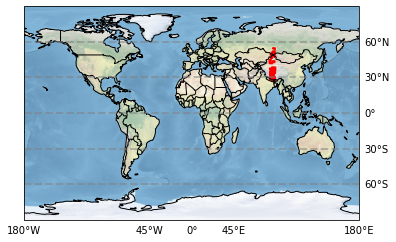

In [41]:
get_bbox_group(granule_ls_32645)

Let's take a closer look at the region of interest, we can do that by specifying bounds when we call the function

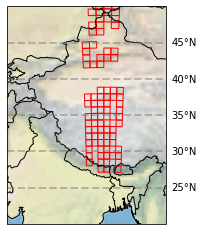

In [40]:
get_bbox_group(granule_ls_32645, [70, 98, 20, 50])

## Selecting granules by a single point

In [42]:
#might need to add a try, except statement to this in case the url doesn't work, or maybe to read_in_s3 fn...
def find_granule_by_point(input_dict, input_point): #[lon,lat]
    '''Takes an inputu dictionary (a geojson catalog) and a point to represent AOI.
    this returns a list of the s3 urls corresponding to zarr datacubes whose footprint covers the AOI'''
    #print([input_points][0])
    
    target_granule_urls = []
    #Point(coord[0], coord[1])
    #print(input_point[0])
    #print(input_point[1])
    point_geom = Point(input_point[0], input_point[1])
    #print(point_geom)
    point_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry = [point_geom])
    for granule in range(len(input_dict['features'])):
        
        #print('tick')
        bbox_ls = input_dict['features'][granule]['geometry']['coordinates'][0]
        bbox_geom = Polygon(bbox_ls)
        bbox_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry = [bbox_geom])
        
        #if poly_gdf.contains(points1_ls[poly]).all() == True:

        if bbox_gdf.contains(point_gdf).all() == True:
            #print('yes')
            target_granule_urls.append(input_dict['features'][granule]['properties']['zarr_url'])
        else:
            pass
            #print('no')
    return target_granule_urls




In [43]:
nepal_url_ls = find_granule_by_point(itslive_catalog, [86.7, 28.07])


Great, this function returned a single url corresponding to the data cube covering the point we supplied

In [44]:
nepal_url_ls

['http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3150000.zarr']

Let's use the `read_in_s3` function we defined to open the datacube as an `xarray.Dataset`

In [51]:
nepal_dc = read_in_s3(nepal_url_ls[0])

and then the `get_bbox_single` function to take a look at the footprint:

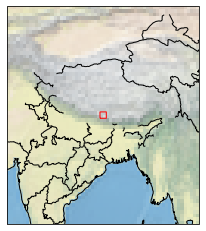

In [52]:
get_bbox_single(nepal_dc)

Great, now we know how to access the its_live data cubes for a given region as well as at a specific point

### 6/14 Trying to calc/show seasonal mean velocities but not working yet... 

In [62]:
#make subset of just a few time steps to start
nepal_sub = nepal_dc.isel(mid_date = slice(0,12))


In [85]:
#explore dt accessors a bit
nepal_sub.mid_date.dt.month

<xarray.DataArray 'month' (mid_date: 12)>
array([ 2,  3, 12,  1,  2,  7, 10,  4, 10,  9,  1,  4])
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2022-02-03T17:00:49.528086016 ... 202...

### Calculate seasonal means using groupby of subset object

In [89]:
#first, split the data into groups, here that is seasons
season_gb = nepal_sub.groupby(nepal_sub.mid_date.dt.season).
season_gb

DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

In [90]:
#define a function to apply to each group
def middate_mean(a):
    return a.mean(dim='mid_date')

In [92]:
#use map to apply function to groups

season_gb.map(middate_mean)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U1'), dtype('<U1')) -> None